In [1]:
import pandas as pd
import numpy as np
import quandl
import os
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import silhouette_score
from scipy.stats import pearsonr

from matplotlib import pyplot as plt
import seaborn as sns
sns.set()

In [2]:
quandl.ApiConfig.api_key = os.environ['QUANDL_']

In [3]:
data = quandl.get_table("ETFG/CONST", paginate=True)

# Data

Data was retrieved from Quandl API, and it is about United States ETFs (Exchange Trade Funds), 25-Dec-2019. This is aimed to probe <b>k-means</b> algorithm looking the best number of clusters which to group the best number of elements minimizing the distance between them.

The official data source can be retrieved from https://www.quandl.com/databases/ETFC/documentation.

In [4]:
data = data[
            [
                'composite_ticker',
                'country_of_exchange',
                'currency_traded',
                'asset_class',
                'security_type',
                'market_value',
                'shares_held'
            ]
        ]

Data used in this excersice is based in seven columns, which are as follow:
- <b>composite_ticker</b> : Ticker identifier for the ETP
- <b>country_of_exchange</b> : Country code for the country in which exchange is located
- <b>currency_traded</b> : Currency code for the local currency of the traded constituent security
- <b>asset_class</b> : Asset class of the underlying constituent. Possible values: Commodities, Equity, Fixed Income, or Real Estate
- <b>security_type</b> : ETF Global taxonomy classification of the underlying constituent, e.g. common equity, domestic, global, etc.
- <b>market_value</b> : Market value of the underlying constituent in USD
- <b>shares_held</b> : Number of shares of the underlying constituent held by the ETP

# Categorial Variables Encodig

Based on https://pbpython.com/categorical-encoding.html

The categorical variables encoding to help to transform categorical variables into numerical values which could be used into segmentation's algorithms, like some used in clustering, like k-means, because major of this algorithms to use numerical calculations which can't be done using categorical values.

Original variables are hold same, but transformed values will be the same column name adding "_code" in the end of the name.

In [5]:
lb_make = LabelEncoder()

columns_to_label_encode = [
                                'composite_ticker',
                                'country_of_exchange',
                                'currency_traded',
                                'asset_class',
                                'security_type',
                            ]

for column_i in columns_to_label_encode:
    data[column_i].fillna('***', inplace=True)
    data[column_i+"_code"] = lb_make.fit_transform(data[column_i])

In [6]:
data.head()

,composite_ticker,country_of_exchange,currency_traded,asset_class,security_type,market_value,shares_held,composite_ticker_code,country_of_exchange_code,currency_traded_code,asset_class_code,security_type_code
None,,,,,,,,,,,,
0,EEM,KR,KRW,Equity,Common Stock,1.241176e+09,661882.0,0,27,18,1,4
1,EEM,HK,HKD,Equity,Common Stock,1.107548e+09,38217800.0,0,19,12,1,4
2,EEM,TW,TWD,Equity,Common Stock,1.031585e+09,165613000.0,0,42,31,1,4
3,EEM,US,USD,Equity,ADR,8.121157e+08,7553159.0,0,43,32,1,1
4,EEM,ZA,ZAR,Equity,Common Stock,5.195372e+08,2946680.0,0,44,33,1,4


# Elbow Method

This is an heuristic method, looking to find the best number of clusters which could be used to group information, trying step by step, increasing the number of clusters and assessing the difference in SSE (Sum Squared Error) between steps.

reference: http://www.iosrjen.org/Papers/Conf.19017-2019/Volume-2/8.%2041-45.pdf

In [7]:
from sklearn.cluster import KMeans
from scipy.spatial import distance

In [8]:
iterations_ = 20
sse_ = {}

columns_2_process = [
                    'composite_ticker_code',
                    'country_of_exchange_code',
                    'currency_traded_code',
                    'asset_class_code',
                    'security_type_code',
                    'market_value',
                    'shares_held'
                ]

for number_of_clusters in range(2,iterations_+1):
    data_2_process = data.copy()
    
    data_2_process = data_2_process[columns_2_process]
    
    kmeans = KMeans(init='k-means++', n_clusters=number_of_clusters, n_init=10)
    kmeans.fit(data_2_process)

    data_2_process['labels'] = kmeans.labels_
    data_2_process['centroid'] = [kmeans.cluster_centers_[i] for i in data_2_process['labels']]
    # kmeans.cluster_centers_

    data_2_process['sse']  = [
                        distance.sqeuclidean(
                            [
                                v['composite_ticker_code'],
                                v['country_of_exchange_code'],
                                v['currency_traded_code'],
                                v['asset_class_code'],
                                v['security_type_code'],
                                v['market_value'],
                                v['shares_held'],
                            ],
                            v['centroid']
                        )
                        for i, v in data_2_process.iterrows()
                    ]
    
    sse_['iteration_'+str(number_of_clusters)] = {
                                'n_clusters' : number_of_clusters,
                                'sse' : data_2_process['sse'].sum(),
                                'silhouette_score' : silhouette_score(
                                                        data_2_process[columns_2_process],
                                                        data_2_process['labels']
                                                        ),
                                'labels' : data_2_process[['labels']].T.values.tolist()[0]
                                }
    del data_2_process

In [9]:
df_see = pd.DataFrame\
            .from_dict(sse_)\
            .T\
            .reset_index(drop=False)\
            .rename(columns={'index':'iteration'})

In [10]:
df_see['see_pct_change'] = df_see['sse'].pct_change() * 100

In [11]:
elbow_point = df_see[df_see['see_pct_change'] > -20]\
                .sort_values('sse', ascending=False)\
                .reset_index(drop=True)\
                .iloc[0]

In [12]:
elbow_point

iteration                                                iteration_10
n_clusters                                                         10
sse                                                       2.10842e+19
silhouette_score                                             0.739979
labels              [3, 3, 3, 3, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, ...
see_pct_change                                               -16.1607
Name: 0, dtype: object

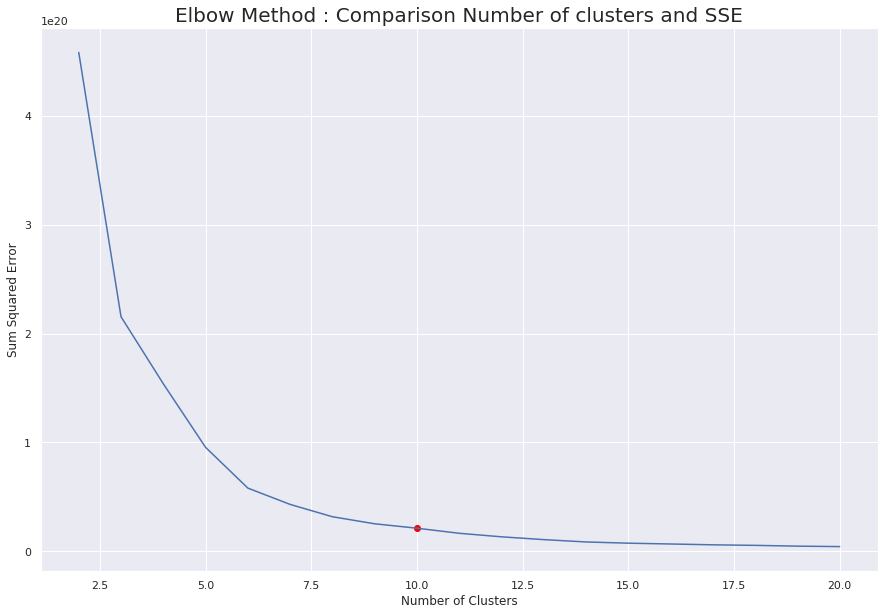

In [13]:
plt.figure(figsize=(15,10))

plt.plot(df_see['n_clusters'], df_see['sse'])
plt.xlabel('Number of Clusters')
plt.ylabel('Sum Squared Error')
plt.title('Elbow Method : Comparison Number of clusters and SSE', fontsize=20)

plt.scatter(elbow_point['n_clusters'], elbow_point['sse'], c='red')

plt.show()

Above we can see the curve where the number of clusters reduce the sum squared error (SSE), but in some point, adding one cluster don't improve SSE significatly. For this reason, the target using Elbow Method is to find the pair (number_of_clusters, sse) which increasing one more of number_of_clusters do not improve much the SSE metric, in this case, 10 clusters.

# Silhouette Score

Is a score, which tell us the distance bwteen one sample in a cluster and its neighboring clusters. This score could take -1 to 1 value, meaning -1 the sample is in wrong cluster, 0 means the sample is nearest to boundary decision, and 1 is the sample is far away from its neighboring clusters which is very good.

references:
* https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html
* https://medium.com/@jyotiyadav99111/selecting-optimal-number-of-clusters-in-kmeans-algorithm-silhouette-score-c0d9ebb11308

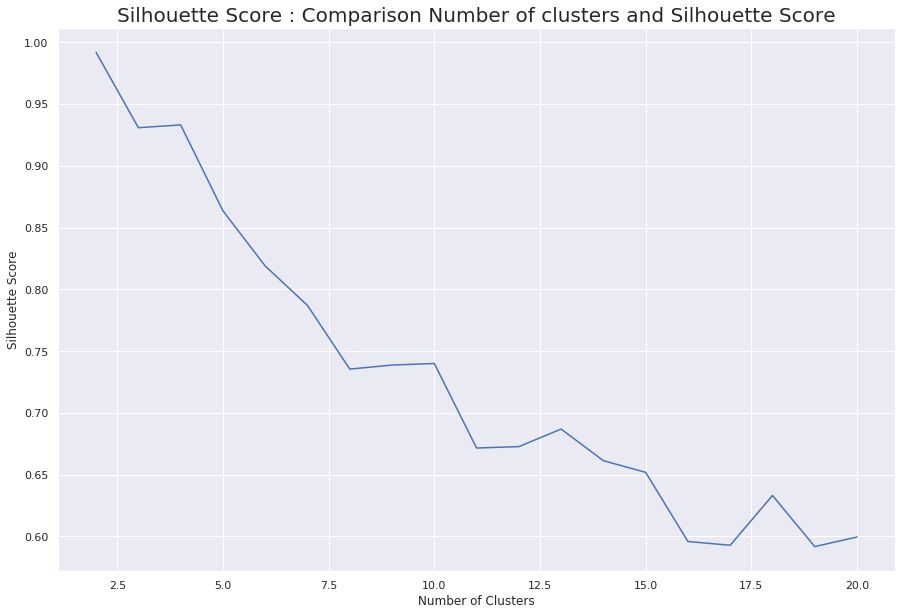

In [14]:
plt.figure(figsize=(15,10))

plt.plot(df_see['n_clusters'], df_see['silhouette_score'])
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score : Comparison Number of clusters and Silhouette Score', fontsize=20)

plt.show()

The image above shows how in all combinations of number of clusters, the silhouette score is above 0.5 which means all samples have a highest distance between them and neighboring clusters than its own clusters, meaning too they was tagged in the right cluster.

# Analysis


In [15]:
data['label'] = df_see[df_see['n_clusters'] == elbow_point['n_clusters']]['labels'].tolist()[0]

In [16]:
data_analysis = data\
                .groupby(['label']+columns_to_label_encode)\
                .agg({'market_value':'sum','shares_held':'sum','composite_ticker_code':'count'})\
                .rename(columns={'composite_ticker_code':'count'})\
                .reset_index(drop=False)

In [17]:
data_analysis.head()

,label,composite_ticker,country_of_exchange,currency_traded,asset_class,security_type,market_value,shares_held,count
0,0,EEM,***,***,***,***,-12728462.32,386213368.0,1
1,0,EEM,***,BRL,Equity,Receipt,1298274.19,417460.0,1
2,0,EEM,***,EUR,***,***,7876195.31,44149034.2,2
3,0,EEM,***,HUF,***,***,16550606.33,237952.0,1
4,0,EEM,***,QAR,Equity,Right,158955.18,117149.0,1


The bigest cluster was the cluster with name cero (0), having 1937 samples, which is the 83.27% of all data. The bigest cluster is no adequately who has the most bigest amount in market value, but it has me bigest amount in shares held.

Over this cluster is analyzed some values, as follow, excluding outliers above 90 percentile and below 10 percentile.

TO BE CONTINUE ::::: >>>>>

<hr>

This could not to be the final version, so if you have some recommendation or comment about this, I will be grateful to hear it, using e-mail <b>craquinterogo@unal.edu.co</b> or <b>cristian.quintero@est.uexternado.edu.co</b>